# Process MPI-ESM2-1-LR SIA & GMST

This notebook processes MPI-ESM2-1-LR (or MPI-GE CMIP6) sea-ice area (SIA) and global mean surface temperature (GMST) data.

More specifically, this workflow:

- Extracts monthly September SIA from the CMIP6 variable ```siarean```.

- Computes global annual mean surface temperature (GMST) from the CMIP6 variable ```tas```.

- Merges the historical and SSP scenario data into long, cohesive time series for analysis.

This script is specifically written to process the data following the folder structure of DKRZ's Levante.

In [ ]:
# General imports
import glob
import re
import os
from tqdm import tqdm

# Data handling
import xarray as xr 
from cdo import Cdo
cdo = Cdo()

# Plotting
import matplotlib.pyplot as plt

# Custom functions
from functions.custom_logger_functions import *

In [ ]:
def get_siarean_files(inpath, member, model, scenario, variable, logger):
    """
    Constructs a file path pattern to locate CMIP6 netCDF files.

    Constructs a file path pattern (using wildcards) to locate CMIP6 netCDF files
    for a specified variable, member, model, and scenario, based on the DKRZ Levante 
    folder structure.

    This function automatically determines the correct version number for the files. It is designed to work
    with both 'siarean' (SImon) and 'tas' (Amon) variables.

    Parameters
    ----------
    inpath : str
        Base input directory path (root of the CMIP6 structure).
    member : str
        Ensemble member ID (e.g., 'r1i1p1f1').
    model : str
        CMIP6 model identifier (e.g., 'MPI-ESM2-1-LR').
    scenario : str
        CMIP6 scenario identifier (e.g., 'historical', 'ssp585').
    variable : str
        CMIP6 variable name ('siarean' or 'tas').
    logger : logging.Logger
        A logger object for outputting debug and warning messages.

    Returns
    -------
    str
        A file path pattern string (e.g., '/path/.../tas_Amon_..._*.nc') 
        which can be used by glob.glob or similar functions.
        
    Warns
    -----
    UserWarning
        If more than one version subdirectory is found for the specified data.
    """

    domains = {"siarean":"SImon", "tas": "Amon"}
    domain = domains[variable]

    logger.debug(inpath + f"{member}/{domain}/{variable}/gn/*")
    versions = [x.split("/")[-1] for x in glob.glob(inpath + f"{member}/{domain}/{variable}/gn/*")]
    #print(versions)
    if len(versions) > 1:
        logger.warning(f"More than one version for: {member}, {scenario}, {versions}")
    version = versions[0]
    
    filepaths = inpath + f"{member}/{domain}/{variable}/gn/{version}/{variable}_{domain}_{model}_{scenario}_{member}_gn_*.nc"
    return filepaths

def safe_remove(file_path, logger):
    """
    Checks for the existence of a file and safely removes it.

    This prevents FileNotFoundError exceptions when attempting to remove
    a non-existent temporary file. The removal is logged at the debug level.

    Parameters
    ----------
    file_path : str
        The full path to the file to be removed.
    
    Returns
    -------
    None
    """
    if os.path.isfile(file_path):
        os.remove(file_path)
        logger.debug(f"Removed {file_path}")

In [ ]:
# Build logger
logger = build_terminal_logger("warning", "mpi-processing")

# Set paths
basepath = "/pool/data/CMIP6/data/"
outpath  = "/work/uo1227/u301557/thesis/data/MPI-ESM2-1-LR/" # with subfolder outvar
activity_id = "ScenarioMIP"

# Select Model, variable, scenarios, ...
model = "MPI-ESM1-2-LR"
modelcenter = "MPI-M"
scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp585"]
variable = "tas" # "tas"

# define name of the output variables
outvars = {"siarean":"sia_nh", "tas": "gmst"}

outvar = outvars[variable]

for scenario in scenarios:
    logger.info(f"Processing {scenario}")
    inpath = f"{basepath}{activity_id}/{modelcenter}/{model}/{scenario}/"
    inpath_hist = f"{basepath}CMIP/{modelcenter}/{model}/historical/"

    # read available numbers and sort
    memberlist = [x.split("/")[-1] for x in glob.glob(inpath + "*")]
    members = sorted(memberlist, key=lambda x: int(re.search(r'r(\d+)i', x).group(1)))

    for member in tqdm(members[:]):
        
        # Build output file names
        if variable == "siarean":
            outfile = outpath + f"{outvar}/{outvar}_{model}_hist_{scenario}_{member}_september.nc"
        elif variable == "tas":
            outfile = outpath + f"{outvar}/{outvar}_{model}_hist_{scenario}_{member}_annual.nc"
        else:
            logger.error(f"Processing not defined for: {variable}")
        
        # If the output file doesnt exist yet, start processing...
        if not os.path.isfile(outfile):
            safe_remove("temp_hist.nc", logger)
            safe_remove("temp_ssp.nc", logger)

            # Get input file names
            ssp_files = get_siarean_files(inpath, member, model, scenario, variable, logger)
            logger.debug(str(ssp_files))
            hist_files = get_siarean_files(inpath_hist, member, model, "historical", variable, logger)
            logger.debug(str(hist_files))

            # Compute output with CDO
            if variable == "siarean":
                cdo.selmon("9", input=f"-chname,siarean,sia_nh -mergetime {ssp_files}", output="temp_ssp.nc")
                cdo.selmon("9", input=f"-chname,siarean,sia_nh -mergetime {hist_files}", output="temp_hist.nc")
            elif variable == "tas":
                cdo.fldmean(input = f"-chname,tas,gmst -yearmean -mergetime {ssp_files}", output="temp_ssp.nc", options ="--reduce_dim")
                cdo.fldmean(input = f"-chname,tas,gmst -yearmean -mergetime {hist_files}", output="temp_hist.nc", options ="--reduce_dim")
            else:
                logger.error(f"Processing not defined for: {variable}")


            files = ["temp_hist.nc", "temp_ssp.nc"]

            # Merge historical with SSP data
            cdo.mergetime(input=files, output = outfile)

            # Check if the file was actually created (CDO in python syntax is sometimes a bit picky with printing errors)
            if os.path.isfile(outfile):
                logger.info(f"Created {outfile}")
            else:
                logger.error(f"Failed to create {outfile}")


    #print(memberlist)

100%|██████████| 50/50 [01:56<00:00,  2.34s/it]


## Quick look at the output data

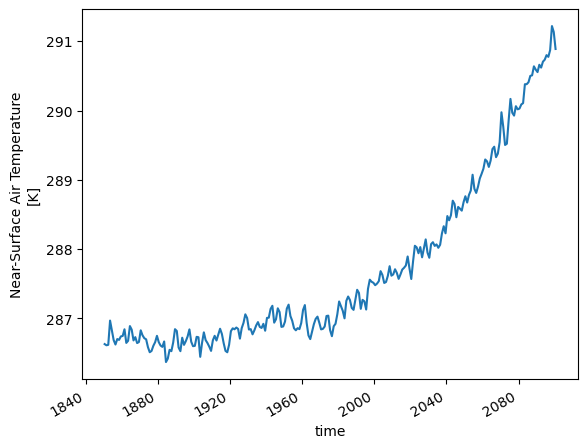

In [22]:
ds = xr.open_dataset(outfile)
ds.gmst.plot()

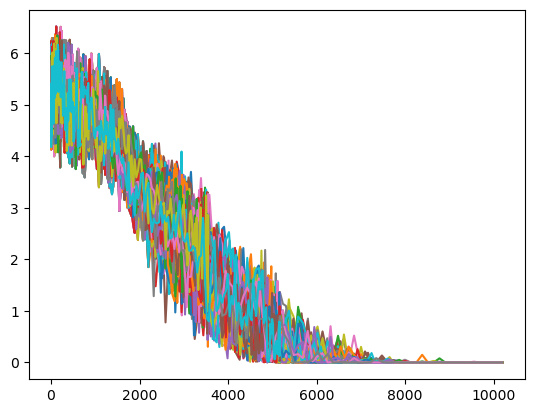

In [ ]:
# Load CMIP6 CO2 data
cmip6_ds = xr.open_dataset("CMIP6_co2_emissions_ssp.nc") # adjust path!
df_co2_cmip6 = cmip6_ds.to_dataframe().cumsum(axis=0)
df_co2_cmip6.index = df_co2_cmip6.index.astype(int)

# Plot SIA agaist CO2
for file in glob.glob(outpath + "*"):
    ds = xr.open_dataset(file)
    scenario = file.split("_")[-3]
    plt.plot(df_co2_cmip6[scenario].loc[1850:2100], ds.sia_nh.values)
    ds.close()